# Data Loading

In [3]:
from datetime import datetime
import time

import requests
import pandas as pd

In [12]:
url = "https://api.bybit.com/v5/market/kline"
symbol = "BTCUSDT"
# spot,linear,inverse
category = "linear"
# 1,3,5,15,30,60,120,240,360,720,D,M,W
interval = 30

In [13]:
timestamp = int(time.time())
values = []

idx = 0

while True:
    params = {
        "symbol": symbol,
        "interval": interval,
        "category": category,
        "start": (timestamp - 200 * 60 * interval) * 1000,
        "end": timestamp * 1000,
        "limit": 200
    }

    response = requests.get(url, params=params)
    response_data = response.json()

    if len(response_data["result"]["list"]) == 0:
        break

    values += response_data["result"]["list"]
    timestamp -= 200 * 60 * interval

    idx += 1

    if idx % 3 == 0:
        time.sleep(0.2)

    if len(values) >= 20000:
        break

In [14]:
data = pd.DataFrame(values)

# カラム名を修正
data.columns = ["timestamp", "open", "high", "low", "close", "volume", "turnover"]
# タイムスタンプをdatetime型に変換
data["datetime"] = (data['timestamp'].astype(int)/1000).apply(datetime.fromtimestamp)
# 昇順に並び替え
data.sort_values("datetime", inplace=True)
# "datetime"をインデックスに設定
data.set_index("datetime", inplace=True)

In [16]:
data.to_csv("data.csv")

In [15]:
data

,timestamp,open,high,low,close,volume,turnover
datetime,,,,,,,
2023-06-03 06:30:00,1685741400000,27150.1,27242.7,27150.1,27200,1037.484,28226790.1921
2023-06-03 07:00:00,1685743200000,27200,27237,27190.4,27232.2,411.52,11201094.1425
2023-06-03 07:30:00,1685745000000,27232.2,27291.9,27227.1,27251.3,1238.456,33765312.9618
2023-06-03 08:00:00,1685746800000,27251.3,27262,27221.3,27224.3,651.537,17753224.1908
2023-06-03 08:30:00,1685748600000,27224.3,27244.8,27221.2,27238.1,407.555,11099871.5743
...,...,...,...,...,...,...,...
2024-07-23 20:00:00,1721732400000,66833.6,66834.3,66403.2,66534.3,3524.273,234727478.3087
2024-07-23 20:30:00,1721734200000,66534.3,66726.2,66462.8,66640.8,1345.896,89715812.3098
2024-07-23 21:00:00,1721736000000,66640.8,66719.5,66452,66487.5,1545.366,102902329.0093


# Data Processing

In [67]:
import polars as pl

In [68]:
df = pl.read_csv("data.csv")
df = df.with_columns(pl.col("datetime").str.to_datetime(format="%Y-%m-%d %H:%M:%S"))
df.head()

datetime,timestamp,open,high,low,close,volume,turnover
datetime[μs],i64,f64,f64,f64,f64,f64,f64
2023-06-03 06:30:00,1685741400000,27150.1,27242.7,27150.1,27200.0,1037.484,2.8227e7
2023-06-03 07:00:00,1685743200000,27200.0,27237.0,27190.4,27232.2,411.52,1.1201e7
2023-06-03 07:30:00,1685745000000,27232.2,27291.9,27227.1,27251.3,1238.456,3.3765e7
2023-06-03 08:00:00,1685746800000,27251.3,27262.0,27221.3,27224.3,651.537,1.7753e7
2023-06-03 08:30:00,1685748600000,27224.3,27244.8,27221.2,27238.1,407.555,1.1100e7


In [7]:
df.shape

(20000, 8)

In [5]:
df.plot(x="datetime", y="close")

:Curve   [datetime]   (close)

In [5]:
df.with_columns(pl.col('close').log().diff().alias("log_return")).plot(x="datetime", y="log_return")

:Curve   [datetime]   (log_return)

In [7]:
df.select(pl.col("log_return")).to_series().plot.hist(bins=50)

:Histogram   [log_return]   (Count)

In [69]:
# positional encoding
import numpy as np

df = df.with_columns(
    pl.col('datetime').dt.month().alias("month"),
    pl.col("datetime").dt.ordinal_day().alias("day_of_year"),
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.weekday().alias("weekday")
    ).with_columns(
        pl.when(pl.col("datetime").dt.minute() < 30).then(pl.col("hour")).otherwise(pl.col("hour") + 0.5).alias("hour")
        ).with_columns(
            (np.pi * pl.col("month") / 6).sin().alias("sin(month)"),
            (np.pi * pl.col("month") / 6).cos().alias("cos(month)"),
            (np.pi * pl.col("day_of_year") / 183).sin().alias("sin(day_of_year)"),
            (np.pi * pl.col("day_of_year") / 183).cos().alias("cos(day_of_year)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )

In [70]:
df = df.with_columns(
    pl.col('close').log().diff().alias("log_return")
    ).with_columns(
        pl.col("log_return").shift(-1).alias("target")
    ).with_columns(
        pl.col("log_return").shift(1).alias("log_return_1"),
        pl.col("log_return").shift(2).alias("log_return_2"),
        pl.col("log_return").shift(3).alias("log_return_3"),
        pl.col("log_return").rolling_mean(5).alias("log_return_rolling_5"),
        pl.col("log_return").rolling_mean(10).alias("log_return_rolling_10"),
        pl.col("log_return").rolling_mean(20).alias("log_return_rolling_20"),
        pl.col("log_return").rolling_mean(30).alias("log_return_rolling_30"),
        pl.col("log_return").rolling_min(5).alias("log_return_min_5"),
        pl.col("log_return").rolling_min(10).alias("log_return_min_10"),
        pl.col("log_return").rolling_min(20).alias("log_return_min_20"),
        pl.col("log_return").rolling_min(30).alias("log_return_min_30"),
        pl.col("log_return").rolling_max(5).alias("log_return_max_5"),
        pl.col("log_return").rolling_max(10).alias("log_return_max_10"),
        pl.col("log_return").rolling_max(20).alias("log_return_max_20"),
        pl.col("log_return").rolling_max(30).alias("log_return_max_30"),
        pl.col("log_return").rolling_std(5).alias("log_return_std_5"),
        pl.col("log_return").rolling_std(10).alias("log_return_std_10"),
        pl.col("log_return").rolling_std(20).alias("log_return_std_20"),
        pl.col("log_return").rolling_std(30).alias("log_return_std_30"),
        pl.col("log_return").rolling_sum(2).alias("log_return_sum_2"),
        pl.col("log_return").rolling_sum(3).alias("log_return_sum_3"),
        pl.col("log_return").rolling_sum(4).alias("log_return_sum_4"),
        pl.col("log_return").rolling_sum(5).alias("log_return_sum_5"),
    ).with_columns(
        (pl.col("log_return") - pl.col("log_return_rolling_5")).alias("log_return_distance_5"),
        (pl.col("log_return") - pl.col("log_return_rolling_10")).alias("log_return_distance_10"),
        (pl.col("log_return") - pl.col("log_return_rolling_20")).alias("log_return_distance_20"),
        (pl.col("log_return") - pl.col("log_return_rolling_30")).alias("log_return_distance_30"),
    ).with_columns(
        (pl.col("log_return") > 0).cast(pl.Float32).rolling_sum(5).alias("log_return_positive_5"),
        (pl.col("log_return") > 0).cast(pl.Float32).rolling_sum(10).alias("log_return_positive_10"),
        (pl.col("log_return") > 0).cast(pl.Float32).rolling_sum(20).alias("log_return_positive_20"),
        (pl.col("log_return") > 0).cast(pl.Float32).rolling_sum(30).alias("log_return_positive_30"),
)   

df = df.with_columns(
    pl.col("volume").log().alias("volume"),
    pl.col("volume").rolling_mean(5).alias("volume_rolling_5"),
    pl.col("volume").rolling_mean(10).alias("volume_rolling_10"),
    pl.col("volume").rolling_mean(20).alias("volume_rolling_20"),
    pl.col("volume").rolling_mean(30).alias("volume_rolling_30"),
)

In [71]:
df = df.drop(["timestamp", "open", "high", "low", "close", "volume", "turnover", "month", "day_of_year", "hour", "day"])
df = df.drop_nulls()

# Training

In [72]:
df = df.with_columns(
    (pl.when((pl.col("weekday")  == 1) & (pl.col("weekday").shift(1) == 7)).then(1).otherwise(0)).cum_sum().alias("num_week")
)

df_copy = df.clone()

df = df.filter((pl.col("num_week") > 0) & (pl.col("num_week") < 60))
df = df.with_columns(
    (pl.col("num_week") - 1).alias("num_week")
)

In [66]:
df

datetime,weekday,sin(month),cos(month),sin(day_of_year),cos(day_of_year),sin(hour),cos(hour),log_return,target,log_return_1,log_return_2,log_return_3,log_return_rolling_5,log_return_rolling_10,log_return_rolling_20,log_return_rolling_30,log_return_min_5,log_return_min_10,log_return_min_20,log_return_min_30,log_return_max_5,log_return_max_10,log_return_max_20,log_return_max_30,log_return_std_5,log_return_std_10,log_return_std_20,log_return_std_30,log_return_sum_2,log_return_sum_3,log_return_sum_4,log_return_sum_5,log_return_distance_5,log_return_distance_10,log_return_distance_20,log_return_distance_30,log_return_positive_5,log_return_positive_10,log_return_positive_20,log_return_positive_30,volume_rolling_5,volume_rolling_10,volume_rolling_20,volume_rolling_30,num_week
datetime[μs],i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,i32
2023-06-05 00:00:00,1,1.2246e-16,-1.0,0.447094,-0.894487,0.0,1.0,-0.001125,-0.001144,0.001525,-0.001827,0.000779,-0.000027,-0.000076,0.000311,0.000183,-0.001827,-0.001827,-0.001827,-0.001828,0.001525,0.001538,0.00182,0.002214,0.001396,0.001148,0.001067,0.00117,0.000401,-0.001426,-0.000647,-0.000136,-0.001097,-0.001048,-0.001436,-0.001307,3.0,4.0,13.0,17.0,1156.1736,846.7071,901.3471,811.8121,0
2023-06-05 00:30:00,1,1.2246e-16,-1.0,0.447094,-0.894487,0.130526,0.991445,-0.001144,-0.000125,-0.001125,0.001525,-0.001827,-0.000358,-0.000168,0.000248,0.000205,-0.001827,-0.001827,-0.001827,-0.001827,0.001525,0.001538,0.00182,0.002214,0.001432,0.001197,0.001115,0.001136,-0.002269,-0.000743,-0.00257,-0.001791,-0.000786,-0.000976,-0.001393,-0.00135,2.0,4.0,12.0,17.0,1293.3936,920.7017,946.33495,831.639467,0
2023-06-05 01:00:00,1,1.2246e-16,-1.0,0.447094,-0.894487,0.258819,0.965926,-0.000125,-0.000059,-0.001144,-0.001125,0.001525,-0.000539,-0.000159,0.000169,0.000129,-0.001827,-0.001827,-0.001827,-0.001827,0.001525,0.001538,0.00182,0.002214,0.001304,0.001197,0.00108,0.001074,-0.001269,-0.002394,-0.000868,-0.002695,0.000414,0.000033,-0.000294,-0.000254,1.0,4.0,11.0,16.0,1165.7786,1016.4541,987.6352,835.9882,0
2023-06-05 01:30:00,1,1.2246e-16,-1.0,0.447094,-0.894487,0.382683,0.92388,-0.000059,0.0011,-0.000125,-0.001144,-0.001125,-0.000185,-0.00011,0.000075,0.000156,-0.001144,-0.001827,-0.001827,-0.001827,0.001525,0.001538,0.001609,0.002214,0.001089,0.00119,0.001008,0.001057,-0.000184,-0.001328,-0.002453,-0.000927,0.000127,0.000051,-0.000134,-0.000215,1.0,4.0,10.0,16.0,970.8398,994.4641,948.3365,839.8945,0
2023-06-05 02:00:00,1,1.2246e-16,-1.0,0.447094,-0.894487,0.5,0.866025,0.0011,-0.000846,-0.000059,-0.000125,-0.001144,-0.000271,0.000117,0.000099,0.000203,-0.001144,-0.001827,-0.001827,-0.001827,0.0011,0.001538,0.001609,0.002214,0.000927,0.001181,0.001027,0.001068,0.001041,0.000916,-0.000228,-0.001353,0.001371,0.000983,0.001001,0.000898,1.0,5.0,10.0,17.0,897.0122,1004.6555,914.11245,847.216967,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-07-21 21:30:00,7,-0.5,-0.866025,-0.336637,-0.941634,-0.608761,0.793353,-0.000297,-0.000812,0.001114,0.001483,-0.000324,0.000039,0.00035,-0.000257,-0.000082,-0.001782,-0.001782,-0.003511,-0.003511,0.001483,0.001577,0.001577,0.001872,0.001304,0.001137,0.001268,0.001221,0.000816,0.0023,0.001976,0.000194,-0.000336,-0.000647,-0.000041,-0.000216,2.0,6.0,8.0,14.0,475.769,706.5952,827.0765,816.5907,58
2024-07-21 22:00:00,7,-0.5,-0.866025,-0.336637,-0.941634,-0.5,0.866025,-0.000812,-0.001618,-0.000297,0.001114,0.001483,0.000233,0.000125,-0.000271,-0.000125,-0.000812,-0.001782,-0.003511,-0.003511,0.001483,0.001577,0.001577,0.001872,0.001003,0.001121,0.001272,0.001223,-0.001109,0.000004,0.001488,0.001164,-0.001045,-0.000937,-0.000541,-0.000687,2.0,5.0,8.0,13.0,487.1412,648.8008,813.2329,793.9615,58
2024-07-21 22:30:00,7,-0.5,-0.866025,-0.336637,-0.941634,-0.382683,0.92388,-0.001618,0.005168,-0.000812,-0.000297,0

In [13]:
#学習関連
n_trials = 100
n_splits = 3
n_estimators = 10000
early_stop_patience = 100

val_size = 1

max_week = int(df.select('num_week').max().to_numpy().squeeze())
min_week = int(df.select('num_week').min().to_numpy().squeeze())

trial_best_iters = []

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
# 検証データの作成
all_train_phases = np.arange(min_week, max_week, 1)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

datasets = []

for train_phases, valid_phases in tscv.split(all_train_phases):
    #データセットの作成
    df_train = df.filter(pl.col("num_week").is_in(train_phases)).to_pandas().drop(["datetime", "num_week"], axis=1)
    df_valid = df.filter(pl.col("num_week").is_in(valid_phases)).to_pandas().drop(["datetime", "num_week"], axis=1)
    
    datasets.append((df_train, df_valid))

In [17]:
def direction_accuracy(y_true, y_pred):
    return ((y_true * y_pred) > 0).mean()

In [18]:
import lightgbm as lgb
import optuna

/Users/kosukekonno/miniconda3/envs/botter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def objective(trial):
    # 探索するパラメータ
    trial_params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e5, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'verbosity': -1,
    }

    val_scores = []
    best_iters = []

    for df_train, df_valid in datasets:
        # モデルの学習 (Early Stoppingあり)
        model = lgb.LGBMRegressor(
            objective='rmse',
            n_estimators=10000,
            **trial_params
        )

        model.fit(
            df_train.drop(['target'], axis=1), df_train['target'],
            eval_set=[(df_valid.drop(['target'], axis=1), df_valid['target'])],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=early_stop_patience,
                    verbose=False
                )
            ]
        )

        iteration = model.best_iteration_
        n_average = 4
        model = VotingRegressor([
            (f'lgbm{i}', lgb.LGBMRegressor(objective='rmse', n_estimators=iteration, random_state=42+i, **trial_params)) for i in range(n_average)
        ])
        model.fit(df_train.drop(['target'], axis=1), df_train['target'])

        y_pred = model.predict(df_valid.drop(['target'], axis=1))
        val_score = direction_accuracy(df_valid['target'], y_pred)
        val_scores.append(val_score)
        
        best_iters.append(iteration)
    
    trial_best_iters.append(best_iters)

    return np.mean(val_scores)

In [31]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials)

# 最適なパラメータを表示
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# 最適なパラメータの取得
tuned_params = trial.params
tuned_iter = int(np.mean(trial_best_iters[trial.number]))

[I 2024-07-26 17:50:33,846] A new study created in memory with name: no-name-05dd574b-6e7a-4520-923f-6f7deb47b31a
[I 2024-07-26 17:50:35,899] Trial 0 finished with value: 0.513888888888889 and parameters: {'num_leaves': 97, 'max_depth': 20, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'reg_alpha': 0.000363233925694314, 'reg_lambda': 0.00036303224667798577, 'learning_rate': 1.7073967431528103e-05}. Best is trial 0 with value: 0.513888888888889.
[I 2024-07-26 17:50:36,399] Trial 1 finished with value: 0.513888888888889 and parameters: {'num_leaves': 222, 'max_depth': 13, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'reg_alpha': 50014.798288569255, 'reg_lambda': 2110.6995036049584, 'learning_rate': 7.068974950624602e-05}. Best is trial 0 with value: 0.513888888888889.
[I 2024-07-26 17:50:39,894] Trial 2 finished with value: 0.5089285714285715 and parameters: {'num_leaves': 48, 'max_depth': 6, 'subsample': 0.6521211214797689, 'colsamp

Best trial:
  Value: 0.5426587301587301
  Params: 
    num_leaves: 225
    max_depth: 6
    subsample: 0.8750533725048678
    colsample_bytree: 0.5527519537916414
    reg_alpha: 0.00022603269326809019
    reg_lambda: 12199.790792209302
    learning_rate: 0.023382203904194498


In [37]:
trial.params

{'num_leaves': 225,
 'max_depth': 6,
 'subsample': 0.8750533725048678,
 'colsample_bytree': 0.5527519537916414,
 'reg_alpha': 0.00022603269326809019,
 'reg_lambda': 12199.790792209302,
 'learning_rate': 0.023382203904194498}

In [90]:
from sklearn.ensemble import VotingRegressor

params = {
    'num_leaves': 240,
    'max_depth': 6,
    'subsample': 0.8908349028148492,
    'colsample_bytree': 0.6097839084290924,
    'reg_alpha': 0.002512266474633023,
    'reg_lambda': 17866.170787949755,
    'learning_rate': 0.030640685008873333,
    'verbosity': -1
    }

iterations = trial_best_iters[trial.number]
iteration = np.max(iterations)

n_average = 8

model = VotingRegressor([
    (f'lgbm{i}', lgb.LGBMRegressor(objective='rmse', n_estimators=iteration, random_state=42+i, **params)) for i in range(n_average)
])

df_train = df.filter(pl.col("num_week") < max_week).to_pandas().drop(["datetime", "num_week"], axis=1)
df_test = df.filter(pl.col("num_week") == max_week).to_pandas().drop(["datetime", "num_week"], axis=1)

model.fit(df_train.drop(['target'], axis=1), df_train['target'])

y_pred = model.predict(df_test.drop(['target'], axis=1))

test_score = direction_accuracy(df_test['target'], y_pred)

print(f"Test Score: {test_score}")

Test Score: 0.49107142857142855


In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [41]:
def objective(trial):
    # 探索するパラメータ
    trial_params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e5, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'verbosity': -1,
    }

    val_scores = []
    best_iters = []

    for df_train, df_valid in datasets:

        df_train['target'] = (df_train['target'] > 0).astype(int)
        df_valid['target'] = (df_valid['target'] > 0).astype(int)

        # モデルの学習 (Early Stoppingあり)
        model = lgb.LGBMClassifier(
            objective='binary',
            n_estimators=10000,
            **trial_params
        )

        model.fit(
            df_train.drop(['target'], axis=1), df_train['target'],
            eval_set=[(df_valid.drop(['target'], axis=1), df_valid['target'])],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=early_stop_patience,
                    verbose=False
                )
            ]
        )

        iteration = model.best_iteration_
        n_average = 4

        model = VotingClassifier([
            (f'lgbm{i}', lgb.LGBMClassifier(objective='binary', n_estimators=iteration, random_state=42+i, **trial_params)) for i in range(n_average)
        ], voting='soft')
        model.fit(df_train.drop(['target'], axis=1), df_train['target'])

        threshold = trial.suggest_float('threshold', 0.35, 0.65)

        y_pred_proba = model.predict_proba(df_valid.drop(['target'], axis=1))[:, 1]
        y_pred = (y_pred_proba > threshold).astype(int)
        val_score = accuracy_score(df_valid['target'], y_pred)
        val_scores.append(val_score)
        
        best_iters.append(iteration)
    
    trial_best_iters.append(best_iters)

    return np.mean(val_scores)

In [42]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials)

# 最適なパラメータを表示
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# 最適なパラメータの取得
tuned_params = trial.params
tuned_iter = int(np.mean(trial_best_iters[trial.number]))

[I 2024-07-26 18:15:28,875] A new study created in memory with name: no-name-c076afc4-f1a7-4490-830f-fb752bed6264
[I 2024-07-26 18:15:34,134] Trial 0 finished with value: 0.4861111111111111 and parameters: {'num_leaves': 97, 'max_depth': 20, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'reg_alpha': 0.000363233925694314, 'reg_lambda': 0.00036303224667798577, 'learning_rate': 1.7073967431528103e-05, 'threshold': 0.6098528437324806}. Best is trial 0 with value: 0.4861111111111111.
[I 2024-07-26 18:15:34,723] Trial 1 finished with value: 0.513888888888889 and parameters: {'num_leaves': 155, 'max_depth': 15, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 2110.6995036049584, 'reg_lambda': 0.001328590390054419, 'learning_rate': 5.3370327626039544e-05, 'threshold': 0.40502135295603015}. Best is trial 1 with value: 0.513888888888889.
[I 2024-07-26 18:15:36,557] Trial 2 finished with value: 0.513888888888889 and parameters: {'num

Best trial:
  Value: 0.5545634920634921
  Params: 
    num_leaves: 75
    max_depth: 9
    subsample: 0.6444647095886056
    colsample_bytree: 0.8667073565079294
    reg_alpha: 1.8363582241958352e-05
    reg_lambda: 51.58572866199828
    learning_rate: 0.0034989494386209533
    threshold: 0.49379721159963386


In [43]:
tuned_params

{'num_leaves': 75,
 'max_depth': 9,
 'subsample': 0.6444647095886056,
 'colsample_bytree': 0.8667073565079294,
 'reg_alpha': 1.8363582241958352e-05,
 'reg_lambda': 51.58572866199828,
 'learning_rate': 0.0034989494386209533,
 'threshold': 0.49379721159963386}

In [ ]:
iterations

In [54]:
params = {
    'num_leaves': 240,
    'max_depth': 6,
    'subsample': 0.8908349028148492,
    'colsample_bytree': 0.6097839084290924,
    'reg_alpha': 0.002512266474633023,
    'reg_lambda': 17866.170787949755,
    'learning_rate': 0.025640685008873333,
    'verbosity': -1
    }

threshold = 0.493797211

iterations = trial_best_iters[trial.number]
iteration = int(np.max(iterations))

n_average = 8

model = VotingClassifier([
    (f'lgbm{i}', lgb.LGBMClassifier(objective='binary', n_estimators=iteration, random_state=42+i, **params)) for i in range(n_average)
], voting='soft')

df_train = df.filter(pl.col("num_week") < max_week).to_pandas().drop(["datetime", "num_week"], axis=1)
df_test = df.filter(pl.col("num_week") == max_week).to_pandas().drop(["datetime", "num_week"], axis=1)

df_train['target'] = (df_train['target'] > 0).astype(int)
df_test['target'] = (df_test['target'] > 0).astype(int)

model.fit(df_train.drop(['target'], axis=1), df_train['target'])

y_pred_proba = model.predict_proba(df_test.drop(['target'], axis=1))[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)

test_score = accuracy_score(df_test['target'], y_pred)

print(f"Test Score: {test_score}")

Test Score: 0.5119047619047619


# backtest

In [73]:
df_backtest = df_copy.filter(pl.col("num_week").shift() == max_week)

In [76]:
df_market = pl.read_csv("data.csv")
df_market = df_market.with_columns(pl.col("datetime").str.to_datetime(format="%Y-%m-%d %H:%M:%S"))

In [78]:
# df_maketとdf_backtestをdatetimeで結合
df_backtest = df_backtest.join(df_market, on="datetime", how="inner")

In [91]:
# y_predを追加
df_backtest = df_backtest.with_columns(
    pl.Series(y_pred, dtype=pl.Float32).alias("y_pred")
)

In [99]:
profits = []
bet = 100000

for i in range(len(df_backtest)):
    position = 1 if df_backtest["y_pred"][i] == 0 else -1
    profit = position * (df_backtest["close"][i] - df_backtest["open"][i]) / df_backtest["open"][i] * bet - 0.00075 * bet
    profits.append(profit)


In [100]:
accumulated_profits = [sum(profits[:i]) for i in range(1, len(profits) + 1)]

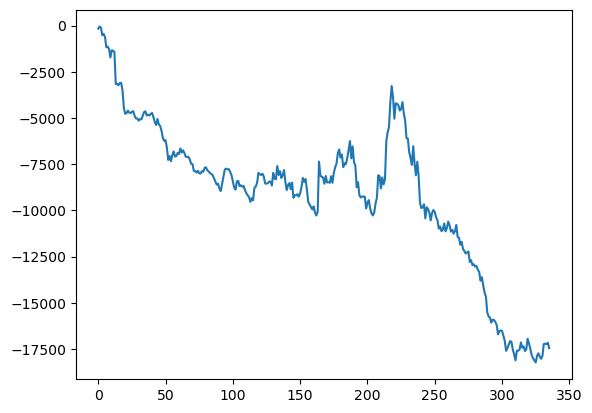

In [101]:
import matplotlib.pyplot as plt

# 折れ線グラフでプロット
plt.plot(accumulated_profits)